In [10]:
import numpy as np
import pandas as pd
import multiprocessing
import os

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('classic')

%matplotlib inline

In [11]:
fileName = os.path.join('resources','data_parsed_short_14012016.pkl')
dfALL = pd.read_pickle(fileName)
print dfALL.shape
print dfALL.info()

(42, 135)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Columns: 135 entries, CODIGO to VISUAL EUROQOL_6
dtypes: bool(34), float64(45), int64(16), object(40)
memory usage: 34.6+ KB
None


In [12]:
feat_type = dict([(c,dfALL[c].dtype.name) for c in dfALL.columns])
print feat_type

{'TRAST_MEM': 'int64', 'MEDIA TAS_3': 'float64', 'AL_IRR_CUT_MAS_6': 'object', 'IMC_3': 'float64', 'MEDIA_TAD_1': 'float64', 'APNEAS_PRES': 'float64', 'IMC_6': 'float64', 'ENF_RESP': 'bool', 'BBLOQ': 'bool', 'BOCA_SECA_6': 'object', 'IAH': 'float64', 'MEDIA_TAS_1': 'float64', 'BOCA_SECA_1': 'object', 'NO_ACTIVO': 'bool', 'CT90%': 'float64', 'OBESIDAD': 'bool', 'BRONCODIL': 'bool', 'EDAD': 'int64', 'AL_IRR_CUT_MASC_1': 'object', 'TALLA_6': 'float64', 'MOV_BRUSC_INV_DUERME': 'object', 'PESO': 'float64', 'EPWORTH_1': 'float64', 'EPWORTH_3': 'float64', 'EPWORTH_6': 'float64', 'ALCOHOL_GR_DIA': 'float64', 'ALCOHOL': 'bool', 'DISM_DESEO_SEX': 'object', 'HEMO_NASAL_6': 'object', 'CONG_NASAL_6': 'object', 'SINUSITIS_3': 'object', 'CONG_NASAL_3': 'object', 'CONG_NASAL_1': 'object', 'ANTIAGREG': 'bool', 'CA-ANTAG': 'bool', 'DIURETICOS': 'bool', 'AL_IRR_CUT_MAS_3': 'object', 'PESO_6': 'float64', 'ESTORNUDOS_1': 'object', 'TIEMPOSAT<90%': 'float64', 'PESO_3': 'float64', 'TALLA': 'float64', 'CRISIS

#### Filter and save data for classifiers

* CLASSIFIERs definition:

 - CL0 -> No data from Month_1, Month_3, Month_6
 - CL0_m1 -> No data from Month_3, Month_3
 - CL0_m3 --> No data from Month_6

 For all of these classifiers the label is Month_6

#### Dataset 3M & 1M monitoring

In [13]:
# Compute label column
dfFilter = dfALL[dfALL.HORAS_USO_MED_NOCHE_6.isnull() == False]
lblCol = dfFilter.HORAS_USO_MED_NOCHE_6.copy()

#lblCol[lblCol[:] <= 4.0] = 0
#lblCol[lblCol[:] > 4.0] = 1

dfLabel = pd.DataFrame(data=lblCol.reshape((len(lblCol),1)), columns=["label"])

#Join mapped label column
npALL= np.hstack((dfFilter,dfLabel))
npCols = list(dfALL.columns)
npCols.append('LABEL')
dfALL6 = pd.DataFrame(data=npALL, columns= npCols)
print dfALL6.shape


#Delete (no relevant) columns
for c in dfALL6.columns:
    if c.find("_6") != -1 \
    or c.find("_LIST") != -1 \
    or c == 'LOC_NEO' or c == 'FECHA_DIAG_NEO' or c == 'TRAT_NEO' \
    or c == 'FECHA_INC' or c == 'FECHA_PRUEBA':
        del dfALL6[c]

print dfALL6.shape
print dfALL6.columns
print len(dfALL6.LABEL.values), dfALL6.LABEL.values

#Add types
for c in dfALL6.columns:
    if c != "LABEL":
        if feat_type[c] == 'float64' or feat_type[c] == 'int64':
            dfALL6[c] = pd.to_numeric(dfALL6[c])
    
print dfALL6.info()

(42, 136)
(42, 115)
Index([u'CODIGO', u'GENERO', u'ACTIVO', u'NO_ACTIVO', u'JUBILADO', u'EDAD',
       u'FUMA', u'FUMA_PAQ_ANY', u'FUMA_EX_ANYS', u'ALCOHOL',
       ...
       u'MEDIA TAD_3', u'PESO_3', u'TALLA_3', u'IMC_3', u'FARMACOS ANADIDOS_3',
       u'FARMACOS QUITADOS_3', u'EPWORTH_3', u'EUROQOL_3', u'VISUAL EUROQOL_3',
       u'LABEL'],
      dtype='object', length=115)
42 [0.0 6.5 5.0 7.0 5.0 7.0 4.0 4.5 7.5 3.32 6.5 3.5 6.51 6.5 6.0 0.0 8.0 5.5
 3.93 3.5 7.0 4.99 7.5 4.0 6.0 2.08 7.5 5.32 8.0 7.0 6.5 2.6 4.0 4.5 0.97
 5.5 7.0 3.8 2.12 7.5 4.0 5.5]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Columns: 115 entries, CODIGO to LABEL
dtypes: float64(35), int64(16), object(64)
memory usage: 37.8+ KB
None


/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


#### Dataset 1M monitoring

In [14]:
# Compute label column
dfFilter = dfALL[dfALL.HORAS_USO_MED_NOCHE_6.isnull() == False]
lblCol = dfFilter.HORAS_USO_MED_NOCHE_6.copy()

#lblCol[lblCol[:] <= 4.0] = 0
#lblCol[lblCol[:] > 4.0] = 1

print lblCol.shape, np.sum(lblCol == 0), np.sum(lblCol == 1)

dfLabel = pd.DataFrame(data=lblCol.reshape((len(lblCol),1)), columns=["label"])
print dfLabel.shape

npALL= np.hstack((dfFilter,dfLabel))
npCols = list(dfALL.columns)
npCols.append('LABEL')
dfALL3 = pd.DataFrame(data=npALL, columns= npCols)
print dfALL3.shape


#Delete (no relevant) columns
for c in dfALL3.columns:
    if c.find("_6") != -1 or c.find("_3") != -1 \
    or c.find("_LIST") != -1 \
    or c == 'LOC_NEO' or c == 'FECHA_DIAG_NEO' or c == 'TRAT_NEO' \
    or c == 'FECHA_INC' or c == 'FECHA_PRUEBA':
        del dfALL3[c]

print dfALL3.shape
print dfALL3.columns
print len(dfALL3.LABEL.values)

#Add types
for c in dfALL3.columns:
    if c != "LABEL":
        if feat_type[c] == 'float64' or feat_type[c] == 'int64':
            dfALL3[c] = pd.to_numeric(dfALL3[c])
    
print dfALL3.info()

(42,) 2 0
(42, 1)
(42, 136)
(42, 94)
Index([u'CODIGO', u'GENERO', u'ACTIVO', u'NO_ACTIVO', u'JUBILADO', u'EDAD',
       u'FUMA', u'FUMA_PAQ_ANY', u'FUMA_EX_ANYS', u'ALCOHOL',
       u'ALCOHOL_GR_DIA', u'CAFES_DIA', u'DEPRESION', u'ANSIEDAD', u'HTA',
       u'CARDIOPATIA', u'ENF_NEUR', u'ENF_RESP', u'DIABETES', u'OBESIDAD',
       u'DISLIPEMIA', u'NEOPLASIA', u'OBSTR_NASAL_CRON', u'CIRUGIA_ORL',
       u'RONCA', u'SUE_REP', u'CRISIS_ASF', u'NICTURIA', u'APNEAS_PRES',
       u'CEFALEA', u'SOMN_DIURN', u'DESPERTAR_NOCT', u'TRAST_MEM',
       u'TRAST_CONC', u'IRR_APAT_DEPR', u'INSOMNIO', u'ACT_MOTR_NOCT',
       u'DOLOR_PIER_MOVER', u'MOV_BRUSC_INV_DUERME', u'SEN_SUE_REAL_DORM',
       u'SUE_INT_PIROSIS', u'FROTA_DIENT_DUERM', u'DISM_DESEO_SEX', u'IECAS',
       u'BBLOQ', u'DIURETICOS', u'CA-ANTAG', u'ARA-II', u'ANTIAGREG',
       u'ANTICOAG', u'ANTIACID', u'BRONCODIL', u'ADO', u'INSULINA',
       u'HIPOLIPEM', u'BDZ', u'ANTIDEPRE', u'OTROS_PSICO', u'OTROS_HIPOT',
       u'TIEMP_SUENO', u'

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


#### Dataset NO monitoring

In [15]:
# Compute label column
dfFilter = dfALL[dfALL.HORAS_USO_MED_NOCHE_6.isnull() == False]
lblCol = dfFilter.HORAS_USO_MED_NOCHE_6.copy()

#lblCol[lblCol[:] <= 4.0] = 0
#lblCol[lblCol[:] > 4.0] = 1
print lblCol.shape, np.sum(lblCol == 0), np.sum(lblCol == 1)

dfLabel = pd.DataFrame(data=lblCol.reshape((len(lblCol),1)), columns=["label"])
print dfLabel.shape

npALL= np.hstack((dfFilter,dfLabel))
npCols = list(dfALL.columns)
npCols.append('LABEL')
dfALL1 = pd.DataFrame(data=npALL, columns= npCols)
print dfALL1.shape


#Delete (no relevant) columns
for c in dfALL1.columns:
    if c.find("_6") != -1 or c.find("_1") != -1 or c.find("_3") != -1 \
    or c.find("_LIST") != -1 \
    or c == 'LOC_NEO' or c == 'FECHA_DIAG_NEO' or c == 'TRAT_NEO' \
    or c == 'FECHA_INC' or c == 'FECHA_PRUEBA':
        del dfALL1[c]
    
print dfALL1.shape
print dfALL1.columns
print len(dfALL1.LABEL.values), dfALL1.LABEL.values

#Add types
for c in dfALL1.columns:
    if c != "LABEL":
        if feat_type[c] == 'float64' or feat_type[c] == 'int64':
            dfALL1[c] = pd.to_numeric(dfALL1[c])
    
print dfALL1.info()

(42,) 2 0
(42, 1)
(42, 136)
(42, 78)
Index([u'CODIGO', u'GENERO', u'ACTIVO', u'NO_ACTIVO', u'JUBILADO', u'EDAD',
       u'FUMA', u'FUMA_PAQ_ANY', u'FUMA_EX_ANYS', u'ALCOHOL',
       u'ALCOHOL_GR_DIA', u'CAFES_DIA', u'DEPRESION', u'ANSIEDAD', u'HTA',
       u'CARDIOPATIA', u'ENF_NEUR', u'ENF_RESP', u'DIABETES', u'OBESIDAD',
       u'DISLIPEMIA', u'NEOPLASIA', u'OBSTR_NASAL_CRON', u'CIRUGIA_ORL',
       u'RONCA', u'SUE_REP', u'CRISIS_ASF', u'NICTURIA', u'APNEAS_PRES',
       u'CEFALEA', u'SOMN_DIURN', u'DESPERTAR_NOCT', u'TRAST_MEM',
       u'TRAST_CONC', u'IRR_APAT_DEPR', u'INSOMNIO', u'ACT_MOTR_NOCT',
       u'DOLOR_PIER_MOVER', u'MOV_BRUSC_INV_DUERME', u'SEN_SUE_REAL_DORM',
       u'SUE_INT_PIROSIS', u'FROTA_DIENT_DUERM', u'DISM_DESEO_SEX', u'IECAS',
       u'BBLOQ', u'DIURETICOS', u'CA-ANTAG', u'ARA-II', u'ANTIAGREG',
       u'ANTICOAG', u'ANTIACID', u'BRONCODIL', u'ADO', u'INSULINA',
       u'HIPOLIPEM', u'BDZ', u'ANTIDEPRE', u'OTROS_PSICO', u'OTROS_HIPOT',
       u'TIEMP_SUENO', u'

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


#### Save dataset

In [16]:
fileName1 = os.path.join('resources','data_filtered_cl0_short_no_monit_14012016.pkl')
fileName3 = os.path.join('resources','data_filtered_cl0_short_1m_monit_14012016.pkl')
fileName6 = os.path.join('resources','data_filtered_cl0_short_3m_1m_monit_14012016.pkl')

dfALL1.to_pickle(fileName1)
dfALL3.to_pickle(fileName3)
dfALL6.to_pickle(fileName6)

df_saved1 = pd.read_pickle(fileName1)
df_saved3 = pd.read_pickle(fileName3)
df_saved6 = pd.read_pickle(fileName6)
print df_saved1.shape, df_saved3.shape, df_saved6.shape

(42, 78) (42, 94) (42, 115)


#### Summary hours nightly along study

,count,mean,std,min,25%,50%,75%,max
HORAS_USO_MED_NOCHE_1,42.00,4.92,2.31,0.00,4.00,5.00,7.00,8.50
HORAS_USO_MED_NOCHE_3,42.00,5.07,2.18,0.00,4.00,5.50,6.97,8.50
HORAS_USO_MED_NOCHE_6,42.00,5.07,2.10,0.00,3.95,5.41,6.88,8.00


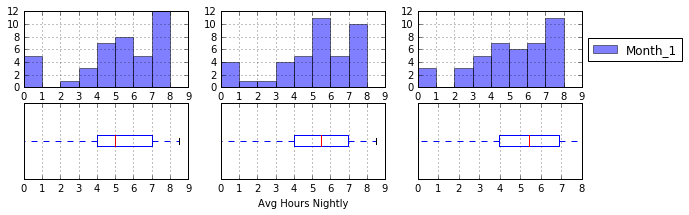

'Anova siginificance test:'

(array([ 0.06756553]), array([ 0.93470113]))

'Kruskal siginificance test:'

KruskalResult(statistic=0.040578820026849712, pvalue=0.97991503504141142)

In [17]:
from IPython.display import display, HTML
from sklearn.feature_selection import RFECV,chi2, f_oneway
from scipy.stats import kruskal

data = dfALL[["HORAS_USO_MED_NOCHE_1","HORAS_USO_MED_NOCHE_3","HORAS_USO_MED_NOCHE_6"]].fillna(0)
display(data.describe().T)


plt.figure(figsize=(10,3))
for i in [0,1,2]:
    ax0 = plt.subplot(2,3,i+1)
    data.iloc[:,i].hist(ax = ax0,bins=range(0,9), label="Month_1", alpha=0.5)
    ax0.set_xlim(0,9)
    if i == 2:
        ax0.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                   
    ax1 = plt.subplot(2,3,i+4)
    data.boxplot(column=data.columns[i],rot=0,vert=False,ax = ax1)
    ax1.set_yticks([],[])
    if i == 1:
        ax1.set_xlabel("Avg Hours Nightly")
plt.show()

display("Anova siginificance test:", f_oneway(data.iloc[:,0].values.astype(float), data.iloc[:,1].values.astype(float), data.iloc[:,2].values.astype(float)))
display("Kruskal siginificance test:", kruskal(data.iloc[:,0].values.astype(float), data.iloc[:,1].values.astype(float), data.iloc[:,2].values.astype(float)))

In [22]:
print np.sum(data.iloc[:,2] == 4)
print np.sum(data.iloc[:,2] > 4)
print np.sum(data.iloc[:,2] >= 4)
print np.sum(data.iloc[:,2] < 4)

4
27
31
11


In [19]:
kont4PlusMonth1 = 0
kont4Plus = 0
kont4 = 0

for i in range(data.shape[0]):
    m1 = data.iloc[i,0]
    m3 = data.iloc[i,1]
    m6 = data.iloc[i,2]
    
    if m1 > 4 and m3 > 4 and m6 > 4:
        kont4Plus += 1
    if m1 >= 4 and m3 >= 4 and m6 >= 4:
        kont4 += 1
    if m1 > 4 and m6 > 4:
        kont4PlusMonth1 += 1
        
print "Equals or above 4h", kont4, kont4/float(data.shape[0])
print "All above 4h:", kont4Plus, kont4Plus/float(data.shape[0])
print "Month_1 and Month_6 above 4h:", kont4PlusMonth1, kont4PlusMonth1/float(data.shape[0])

Equals or above 4h 25 0.595238095238
All above 4h: 20 0.47619047619
Month_1 and Month_6 above 4h: 20 0.47619047619
